An example to explore sensible ways to set up logistic models - thinking about when features should be included as main effects vs. when they should be used only within interaction terms. This model also becomes a baseline for introducing multi-level varients to capture groupings in the data (see ./multilevel/multiple_varying_intercepts_regression.ipynb).

Chimps are sat at a table, either opposite an empty chair, or another chimp. Two levers, left and right, are available to the chimp. Both return a meal to the chimp, but only one also returns a meal to the other end of the table. Do chimps go for the pro-social option?

The dataset just contains the data for the left lever, as this tells the full story. The `actor` variable represents which chimp is in the trial. `condition` = 1 when another chimp is at the other end of the table, and `condition` = 0 for the control condition where the chair opposite is empty.

There is no reason to hypothesize that the presence of absence of another animal creates a tendency to pull the left-hand lever. So there should be no main effect in the model for the `condition` variable. Instead, the strength of the association between pulling left and the prosocial option being left should depend on the condition variable.

L ~ Binomial(1,p)
p ~ logistic_func( alpha + (betaP + betaPC*C) * P)

where C is `condition`, and P is `prosocial`

To begin with, the model will pool all chimps together by ignoring the `actor` variable.

In [1]:
import numpy as np
import stan
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
df = pd.read_csv('../datasets/chimps.csv',sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [19]:
model = '''
data {
    int<lower=1> N;
    int<lower=0, upper=1> l[N];
    int<lower=0,upper=1> c[N];
    int<lower=0,upper=1> p[N];
}
parameters {
    real alpha;
    real betaP;
    real betaPC;
}
model {
    alpha ~ normal(0,10);
    betaP ~ normal(0,10);
    betaPC ~ normal(0,10);

    for (n in 1:N) {
        l[n] ~ binomial(1, inv_logit( alpha + (betaP + (betaPC * c[n])) * p[n]) ); 
    }
}
'''
posterior = stan.build(program_code=model,data={
    "N" : len(df['pulled_left'].to_list()),
    "l" : df['pulled_left'].to_list(),
    "c" : df['condition'].to_list(),
    "p" : df['prosoc_left'].to_list()

})
fit = posterior.sample(num_chains=4, num_warmup=1000, num_samples=1000)
az_fit = az.from_pystan(posterior=fit,
                        posterior_model=posterior,
                        observed_data="l")

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_lu36wgk2/model_ewmtgyha.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_lu36wgk2/model_ewmtgyha.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_lu36wgk2/model_ewmtgyha.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will b

array([[<Axes: title={'center': 'betaP'}>,
        <Axes: title={'center': 'betaP'}>],
       [<Axes: title={'center': 'betaPC'}>,
        <Axes: title={'center': 'betaPC'}>]], dtype=object)

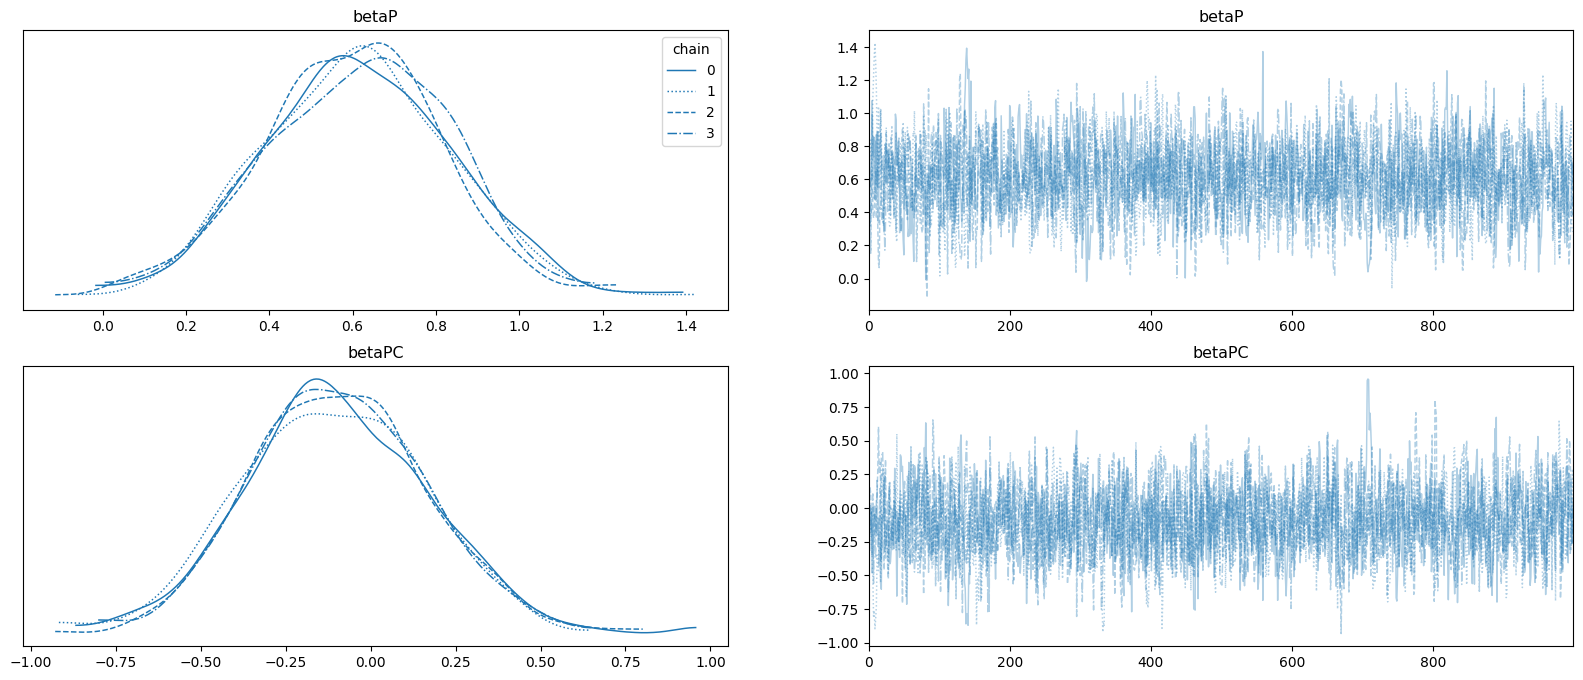

In [21]:
az.plot_trace(az_fit, ["betaP","betaPC"], figsize=(20,8), legend=True)

It would also be possible to use a no-pooling approach by treating each chimp seperately - giving each chimp an independant model intercept.